In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt 
import pennylane as qml
import pennylane.numpy as np 
from main import *

In this notebook we present the sytaxis to create and evaluate quantum states and operators in first quantization in a qubit-based quantum computer. In the first place let us define the number of qubits and the device to perform the simulations.

In [2]:
num_wires = 3
dev = qml.device( "default.qubit", 
                    wires=2*num_wires, shots=100)

Second, we create discrete versions of the position operator $X$ and the momentum operator $P$ between $x_{min}=-5$ and $x_{max}=5$ with the function ```X_and_P_ops``` 

In [3]:
X, P = X_and_P_ops( range(num_wires), -5, 5 )   
X, P 

(<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>)

We now will evaluate the expected value of those operators in a random quantum state $|\psi\rangle$.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

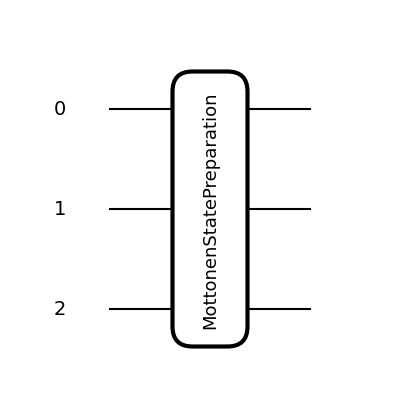

In [4]:
def psi( params ):
    qml.MottonenStatePreparation( params, range(num_wires ) )

np.random.seed(0)
params = np.random.randn(2**num_wires) + 1j*np.random.randn(2**num_wires) 
params = params / np.linalg.norm( params )

qml.draw_mpl(psi)(params) 

We can evaluate the expecting value of $X$ or $P$ over $|\psi\rangle$ creating the corresponding __quantum tape__ with the function ```tapes_XP```.

In [5]:
tape_X = tapes_XP( params, psi, X )
print( tape_X[0].draw() )

0: ─╭MottonenStatePreparation(M0)─┤ ╭<None>
1: ─├MottonenStatePreparation(M0)─┤ ├<None>
2: ─╰MottonenStatePreparation(M0)─┤ ╰<None>
M0 = 
[ 0.41768427-0.02443969j  0.0947474 +0.09721964j  0.23174112+0.03410598j
  0.53058848+0.34433625j  0.44219187+0.18019504j -0.2313954 +0.02880966j
  0.2249576 +0.10509591j -0.03583767+0.07900589j]


The expectel value is given by the function ```exp_val_XP```.

In [6]:
exp_val_XP( circuit_tapes=tape_X, device=dev )

-0.8072673075874343

We can also simple give directly to ```exp_val_XP``` the arguments of ```tapes_XP``` plus the device

In [7]:
exp_val_XP( params, psi, X, dev )

-0.8072673075874343

For the evaluation of $P$ the tape include the Fourier Transfom inorder to change the basis from the eigenbasis of $X$ to the eigenbasis of $P$. 

In [8]:
tape_P = tapes_XP( params, psi, P )
print( tape_P[0].draw() )

0: ─╭MottonenStatePreparation(M0)──H─╭●──╭●────────────┤ ╭<None>
1: ─├MottonenStatePreparation(M0)────╰Rϕ─│────H─╭●─────┤ ├<None>
2: ─╰MottonenStatePreparation(M0)────────╰Rϕ────╰Rϕ──H─┤ ╰<None>
M0 = 
[ 0.41768427-0.02443969j  0.0947474 +0.09721964j  0.23174112+0.03410598j
  0.53058848+0.34433625j  0.44219187+0.18019504j -0.2313954 +0.02880966j
  0.2249576 +0.10509591j -0.03583767+0.07900589j]


In [9]:
exp_val_XP( circuit_tapes=tape_P, device=dev )

-0.3321309682481336

Setting the input ```semiclassical=True``` of ```X_and_P_ops```, the evaluation of $P$ is perform with a semiclassical implementation of the Fourier transform. This replaces the controlled operations with mid-circuit measurements and classical controls.

In [10]:
X, P = X_and_P_ops( range(num_wires), -5, 5, semiclassical=True )   
tape_P = tapes_XP( params, psi, P )
print( tape_P[0].draw() )

0: ─╭MottonenStatePreparation(M0)──H──┤↗├─────────────────────┤ ╭<None>
1: ─├MottonenStatePreparation(M0)──────║───Rϕ──H───┤↗├────────┤ ├<None>
2: ─╰MottonenStatePreparation(M0)──────║───║───Rϕ───║───Rϕ──H─┤ ╰<None>
                                       ╚═══╩═══╝    ║   ║              
                                                    ╚═══╝              
M0 = 
[ 0.41768427-0.02443969j  0.0947474 +0.09721964j  0.23174112+0.03410598j
  0.53058848+0.34433625j  0.44219187+0.18019504j -0.2313954 +0.02880966j
  0.2249576 +0.10509591j -0.03583767+0.07900589j]


To obtain a better plot we can call the Fourier Transform we can export directly from the operation `QFT`.

(<Figure size 1300x500 with 1 Axes>, <Axes: >)

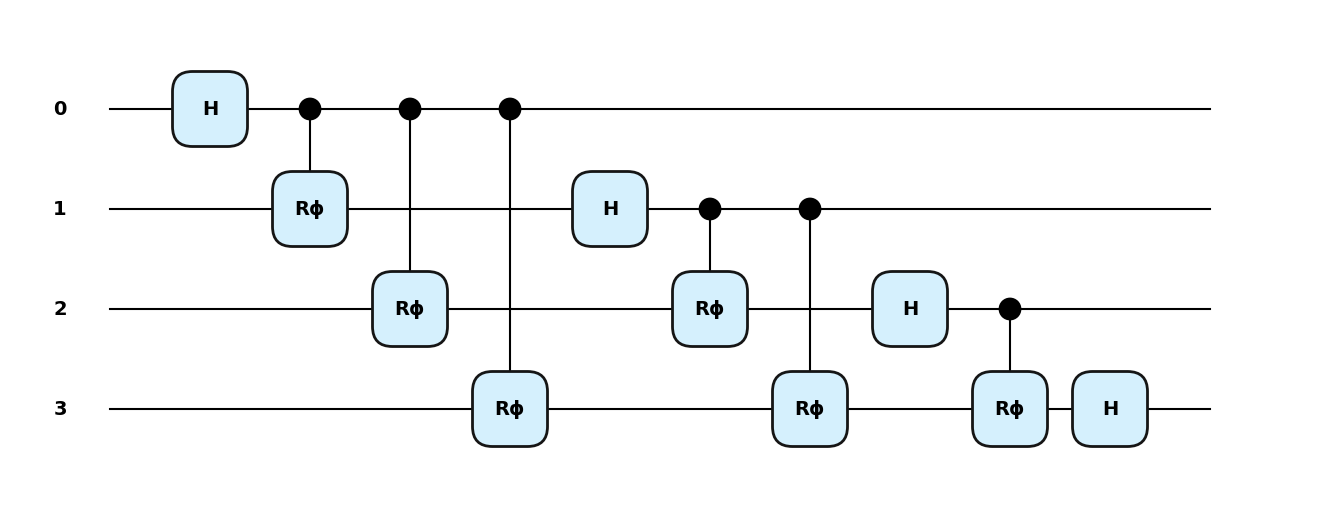

In [26]:
qft = QFT( range(num_wires+1), semi_classical=False )
def fun():
    qft.decomposition()
    # return qml.probs(range(4))
qml.draw_mpl(fun, style='pennylane')()
# plt.savefig('../figures/circuit_qft.pdf')

(<Figure size 1400x625 with 1 Axes>, <Axes: >)

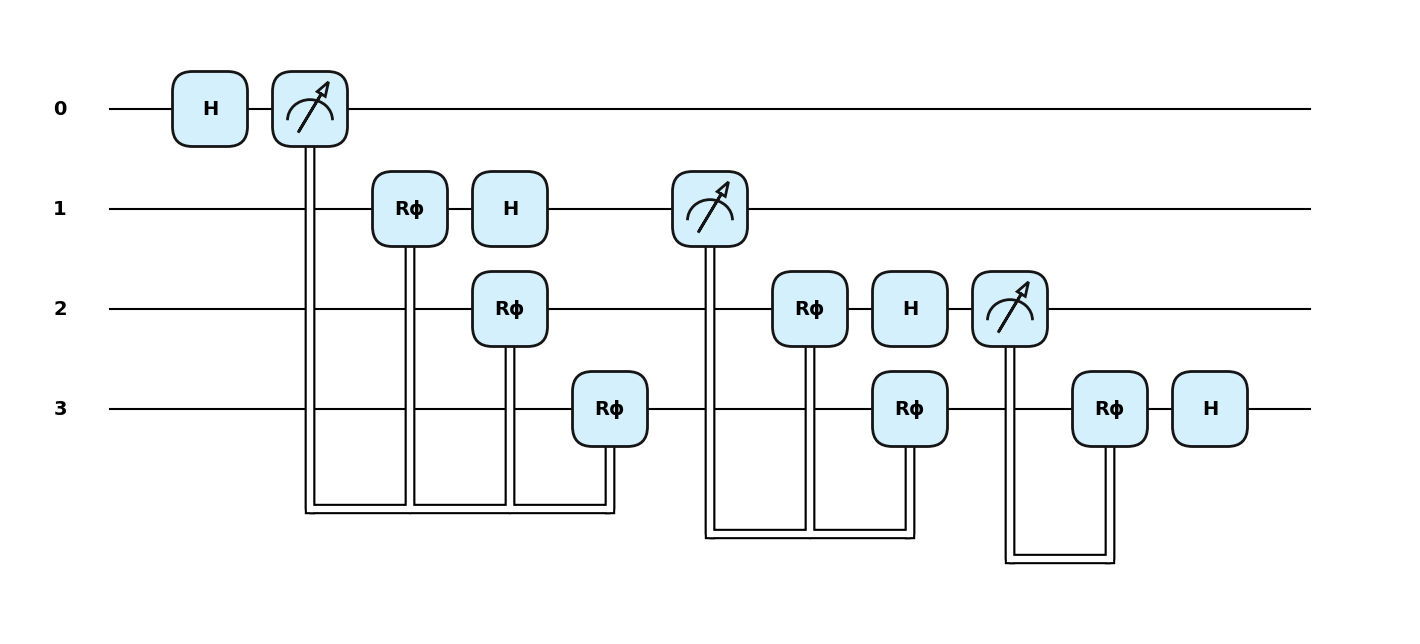

In [27]:
qft = QFT( range(num_wires+1), semi_classical=True )
def fun():
    qft.decomposition()
qml.draw_mpl(fun, style='pennylane')()
# plt.savefig('../figures/circuit_scqft.pdf')

This circuits gives the same expectied value than the standard implementation.

In [14]:
exp_val_XP( circuit_tapes=tape_P, device=dev )

-0.3321309682481336

We can also evaluate arbitrary quadrature operator $Q=aX+bP$ puting each term of the sum in a ```list```.

In [15]:
a = 1
b = 1

Q = [ qml.s_prod( a, X ), qml.s_prod( a, P ) ]
Q 

[1*(  (1) [Hermitian0,1,2]), 1*(  (1) [Hermitian0,1,2])]

In this case the program perform a simulation for each term in the list.

In [16]:
exp_val_XP( params, psi, Q, dev )

-1.1393982758355679

The function ```exp_val_XP``` is differentiable.

In [17]:
qml.grad(exp_val_XP)( params, psi, Q, dev )

tensor([-3.8870299 -0.67169265j,  0.11715474+1.12149215j,
        -1.19609183-0.59190087j,  0.71705667-0.56763711j,
         1.57439009+0.22945574j, -1.0249129 -0.11467149j,
         1.4696715 -1.30383079j,  0.32971311-0.85879714j], requires_grad=True)

In [18]:
qft = QFT( range(5), True )

In [19]:
def fun():
    qft.decomposition()

(<Figure size 1900x750 with 1 Axes>, <Axes: >)

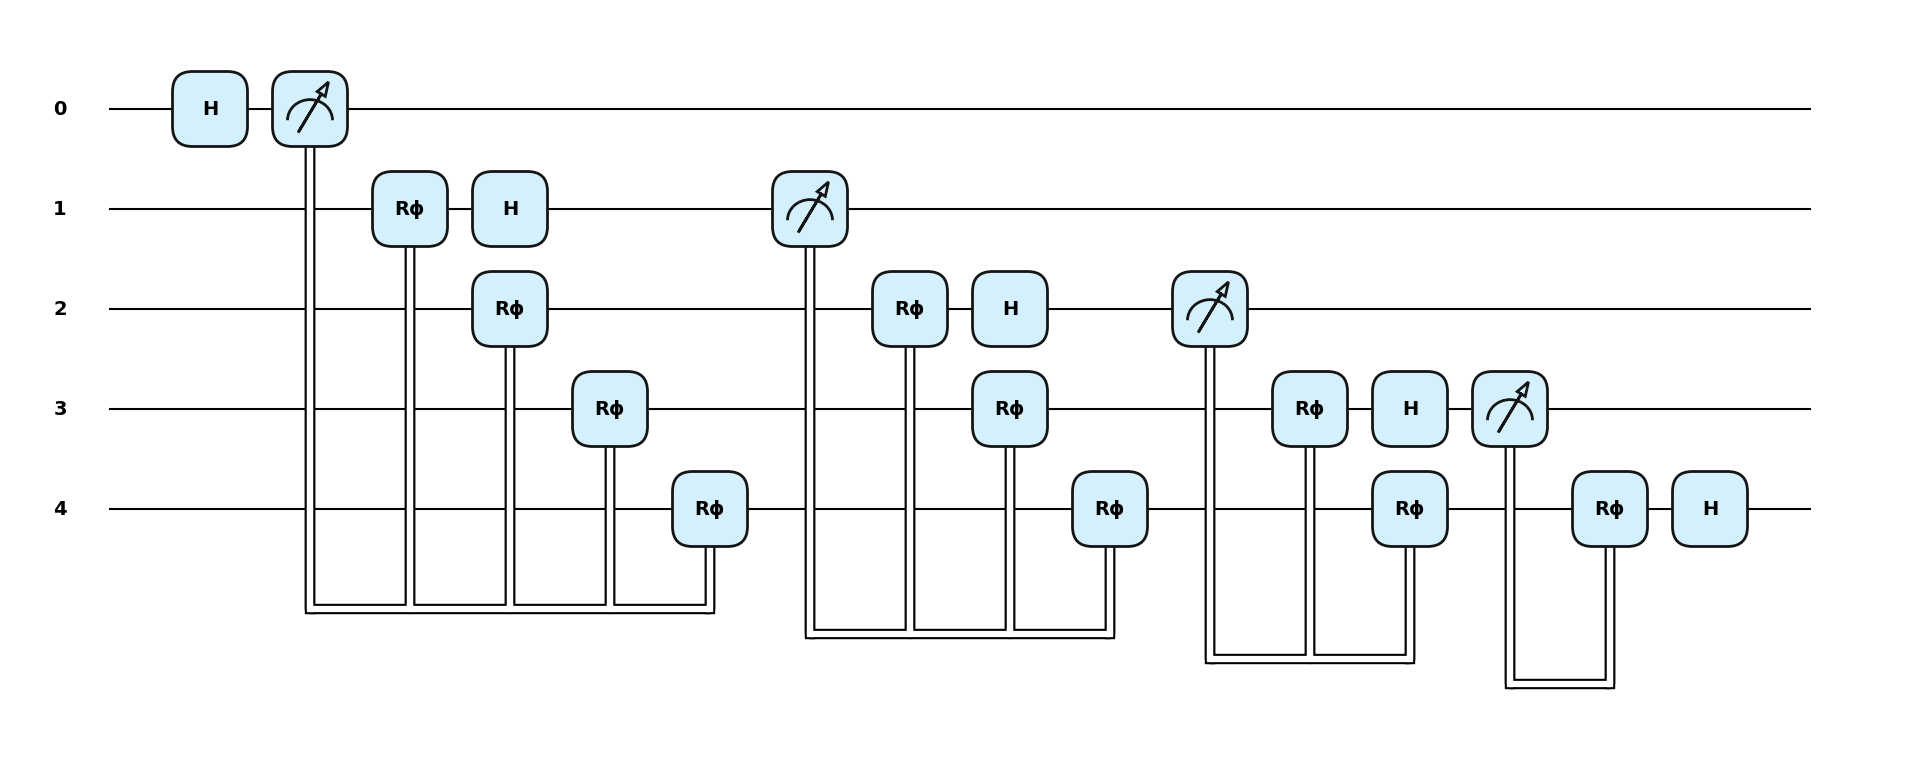

In [20]:
qml.draw_mpl(fun, style='pennylane')()